In [21]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import optuna

In [22]:
import os
import re

In [23]:
from perform_visualization import perform_eda, perform_eda_short, performance_visualizations

In [24]:
random_seed = 42
early_stopping_round = 100

In [25]:
stat_path = os.path.join(os.getcwd())
pattern = re.compile(r'output_*\d')
folder_paths =[]
for folder_name in os.listdir(stat_path):
    if pattern.match(folder_name):
        folder_paths.append(folder_name)

In [26]:
filename_features = "features_full.csv"
filename_target = "target_full.csv"

In [27]:
folder_paths = ["output_28_12_2024"]

In [28]:
X = pd.DataFrame()
y = pd.DataFrame()
for folder in folder_paths:
    X_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_features)
    y_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_target)
    
    is_unnamed = pd.isna(X_tmp.columns[0]) or str(X_tmp.columns[0]).startswith('Unnamed:')
    is_unnamed_y = pd.isna(y_tmp.columns[0]) or str(y_tmp.columns[0]).startswith('Unnamed:')
    if is_unnamed:
        X_tmp = X_tmp.drop(X_tmp.columns[0], axis=1)
    if is_unnamed_y:
        y_tmp = y_tmp.drop(y_tmp.columns[0], axis=1)
    
    if X_tmp.columns[0] != "y":
        col_y = np.ones(X_tmp.shape[0]) * 1000
        X_tmp.insert(0, "y", col_y)
    
    print(X_tmp.shape, y_tmp.shape)
    X = pd.concat([X, X_tmp], axis = 0)
    y = pd.concat([y, y_tmp], axis = 0)
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
X.shape, y.shape

(1034880, 9) (1034880, 4)


((1034880, 9), (1034880, 4))

In [29]:
#Delete zeros
mask = (y["c_std_y"] != 0) & (y["c_std_z"] != 0)
X = X[mask]
y = y[mask]

In [30]:
points = np.linspace(0, np.max(y["c_std_y"]), 200)
quantiles = np.histogram(y["c_std_y"], points)
hist_mode = quantiles[1][np.argmax(quantiles[0])]

In [31]:
cut_mask = y["c_std_y"] >= hist_mode
X = X[cut_mask]
y = y[cut_mask]
X.shape, y.shape

((1007156, 9), (1007156, 4))

In [12]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

## Full empiric model

In [13]:
I_y = 0.88/(np.log(X_test["z"]/X_test["roughness"]) - 1)
I_z = 0.5/(np.log(X_test["z"]/X_test["roughness"]) - 1)
std_y = I_y * X_test["distances"]
std_z = I_z * X_test["distances"]

In [14]:
y_pred = {
    "c_mean_z" : np.array(X_test["z"]),
    "c_mean_y" : np.array(X_test["y"]),
    "c_std_z" : np.array(std_z),
    "c_std_y" : np.array(std_y)
}

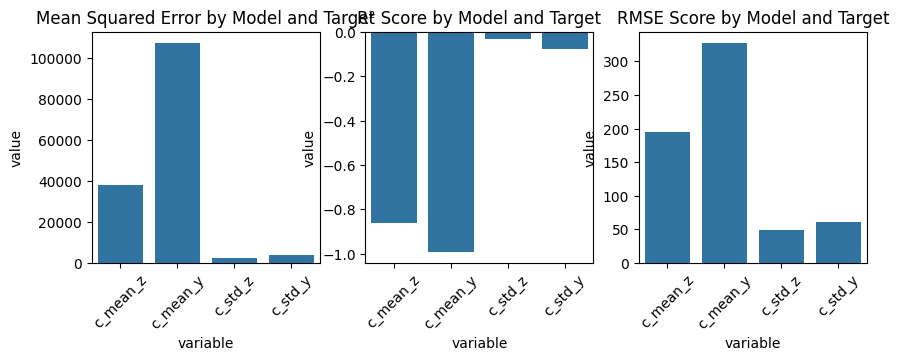

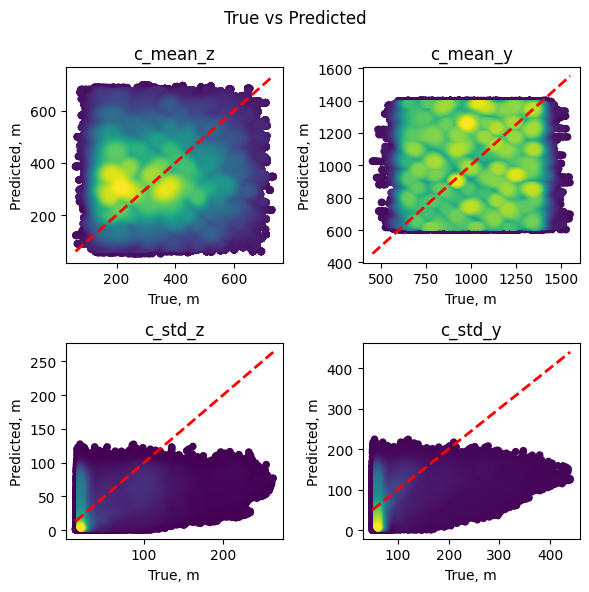

                    mse        r2        rmse
c_mean_z   38207.854318 -0.860483  195.468295
c_mean_y  107384.838559 -0.991743  327.696260
c_std_z     2422.037292 -0.034207   49.214198
c_std_y     3772.219202 -0.075558   61.418395


In [15]:
performance_visualizations(y_pred, y_test)

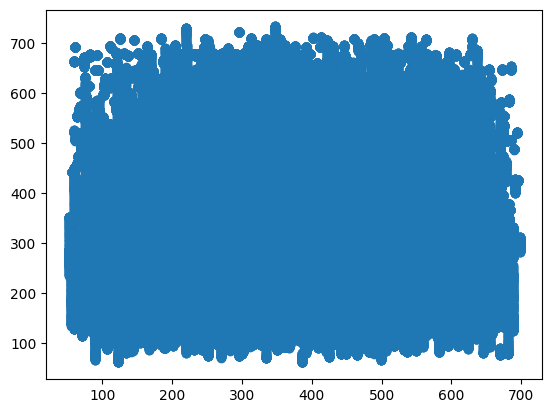

In [32]:
plt.scatter(X["z"], y["c_mean_z"])

In [34]:
X["z"]

0          464.154117
1          464.154117
2          464.154117
3          464.154117
4          464.154117
              ...    
1034875    276.819105
1034876    276.819105
1034877    276.819105
1034878    276.819105
1034879    276.819105
Name: z, Length: 1007156, dtype: float64

In [35]:
y["c_mean_z"]

0          222.262336
1          222.486919
2          222.634770
3          222.910043
4          223.122399
              ...    
1034875    536.401207
1034876    536.433928
1034877    536.483176
1034878    536.511682
1034879    536.560089
Name: c_mean_z, Length: 1007156, dtype: float64

## Briggs parametrisation

In [16]:
def func(x, alpha, beta, gamma):
    return alpha*x*(1+beta*x)**gamma

In [17]:
def objective(trial):
    param = {
        'alpha': trial.suggest_float("alpha", 0.08, 0.06),
        'beta': trial.suggest_float('beta', 0.0001, 0.0015),
        'gamma': trial.suggest_int('gamma', -0.5),
    }
    result = func(x = X_train["distances"], **param)

    loss = root_mean_squared_error(y_train, result)
    return loss

In [18]:
%%time
study = optuna.create_study(study_name=f'briggs-seed{random_seed}')
study.optimize(objective, n_trials=1000, timeout=7200)

[I 2025-02-17 21:44:04,643] A new study created in memory with name: briggs-seed42
[W 2025-02-17 21:44:04,644] Trial 0 failed with parameters: {} because of the following error: ValueError('The `low` value must be smaller than or equal to the `high` value (low=0.08, high=0.06).').
Traceback (most recent call last):
  File "/home/igerasimov/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25554/1431439691.py", line 3, in objective
    'alpha': trial.suggest_float("alpha", 0.08, 0.06),
  File "/home/igerasimov/.local/lib/python3.10/site-packages/optuna/trial/_trial.py", line 160, in suggest_float
    distribution = FloatDistribution(low, high, log=log, step=step)
  File "/home/igerasimov/.local/lib/python3.10/site-packages/optuna/distributions.py", line 143, in __init__
    raise ValueError(
ValueError: The `low` value must be smaller than or equal to the `high` value (low=0.08, high=0.06).
[W

ValueError: The `low` value must be smaller than or equal to the `high` value (low=0.08, high=0.06).

In [19]:
print(study.best_value)
print(study.best_params)

ValueError: No trials are completed yet.

In [ ]:
result = func(x = X_test["distances"], **study.best_params)
performance_visualizations(result, y_test)